In [1]:
import sys
from scipy import ndimage
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import seaborn as sns
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from collections import namedtuple

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [57]:
# how large should the image be
SIZE = 16

# labels every
LABELS = 5

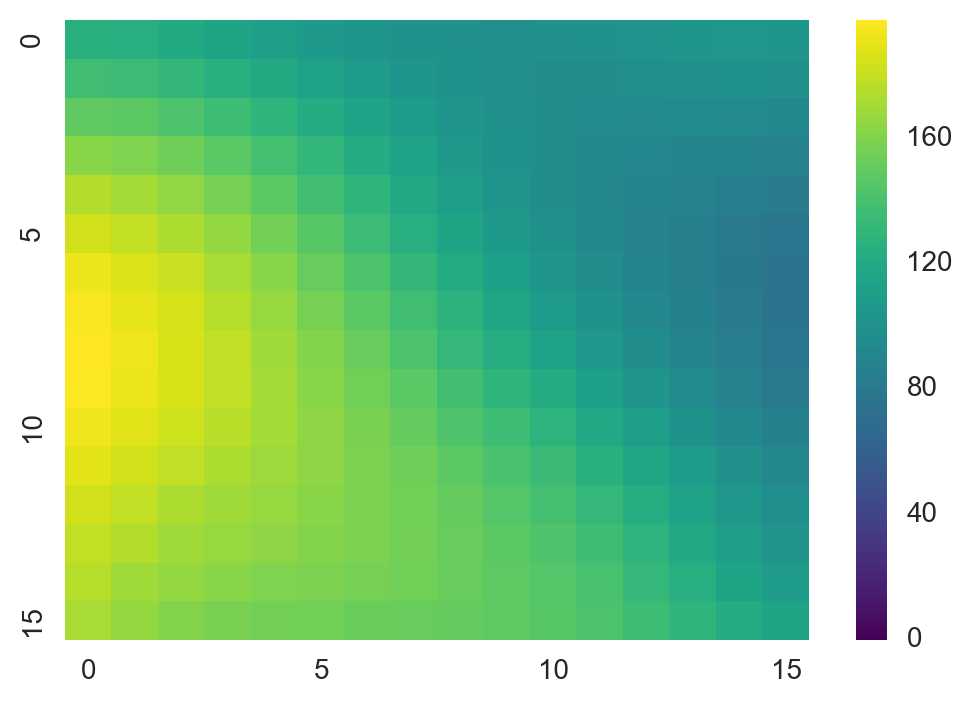

In [58]:
values = ndimage.imread('img/noise1.png', flatten=True)[0:SIZE,0:SIZE]
sns.heatmap(values, cmap='viridis', vmin=0, xticklabels=LABELS, yticklabels=LABELS)

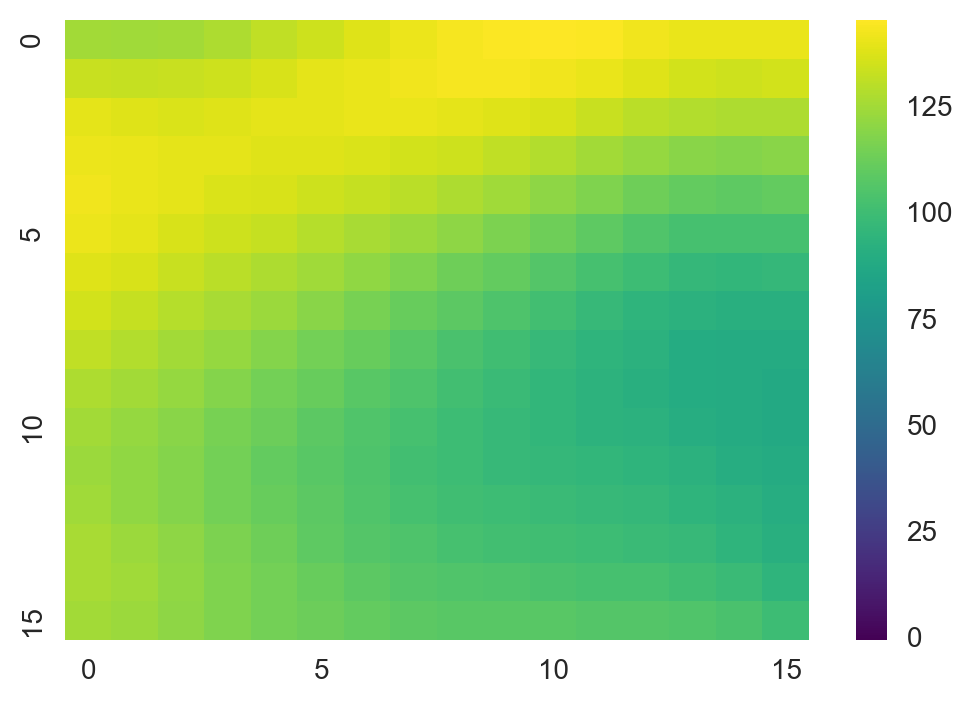

In [59]:
counts = ndimage.imread('img/noise2.png', flatten=True)[0:SIZE,0:SIZE]
sns.heatmap(counts, cmap='viridis', vmin=0, xticklabels=LABELS, yticklabels=LABELS)

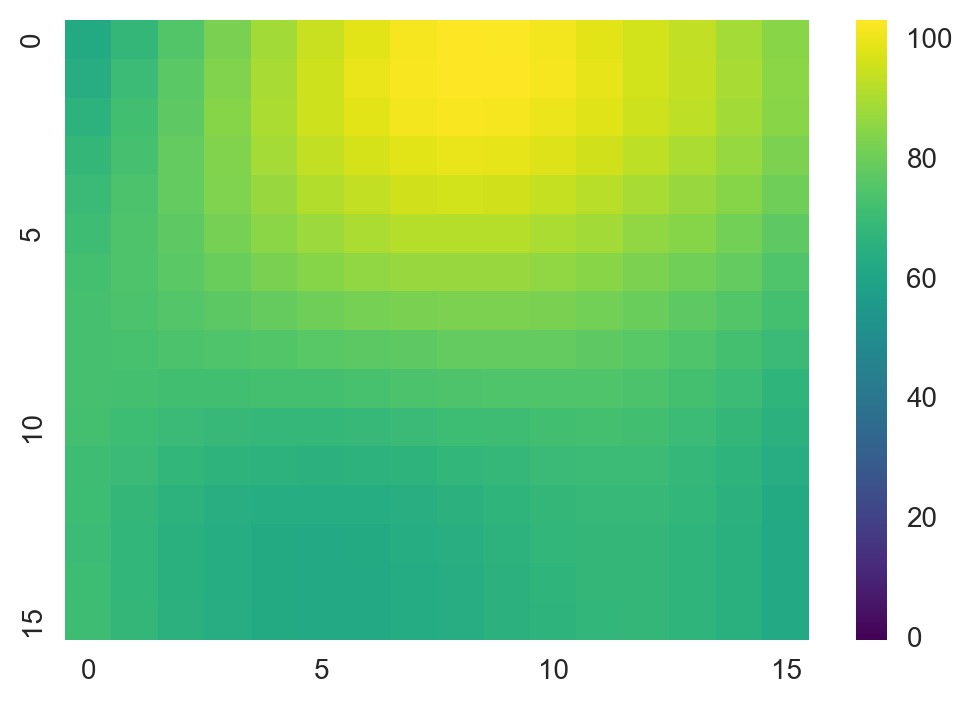

In [66]:
uncertainties = ndimage.imread('img/noise3.png', flatten=True)[0:SIZE,0:SIZE]/2
sns.heatmap(uncertainties, cmap='viridis', vmin=0, xticklabels=LABELS, yticklabels=LABELS)

In [67]:
w = values.shape[0]
h = values.shape[1]

ids = np.arange(w*h).reshape(values.shape)

In [68]:
# data structure to help us keep track of which cells are in a contracted node
Cell = namedtuple('Cell', ['x', 'y'])

G = nx.Graph()

# create nodes
for x in range(w):
    for y in range(h):
        c = Cell(x, y)
        G.add_node(y*w+x, cells=set([c]), v=values[x][y], c=counts[x][y], u=uncertainties[x][y])

# create edges
for x in range(w):
    for y in range(h):
        if (x+1<w):
            G.add_edge(y*w+x, y*w+x+1)
        if (y+1<h):
            G.add_edge(y*w+x, (y+1)*w+x)

# print some stats to check for sanity
G.number_of_nodes(), G.number_of_edges(), G.node[0]

(256, 480, {'c': 126.0, 'cells': {Cell(x=0, y=0)}, 'u': 63.0, 'v': 126.0})

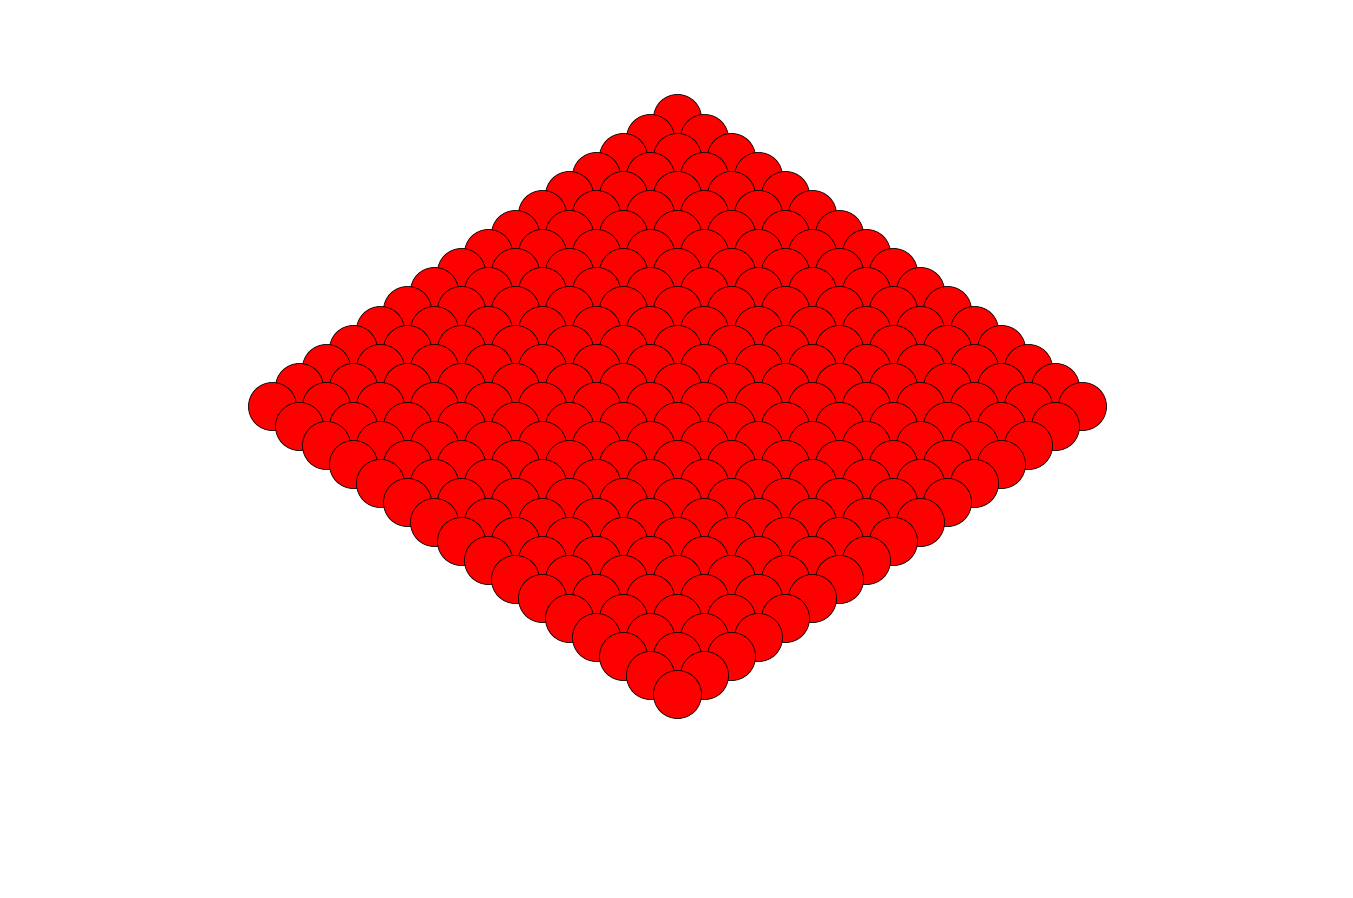

In [69]:
positions = graphviz_layout(G, prog='dot')
nx.draw(G, pos=positions)

\begin{aligned}
\mu _{X\cup Y}&={\frac {N_{X}\mu _{X}+N_{Y}\mu _{Y}}{N_{X}+N_{Y}}}\\[3pt]\sigma _{X\cup Y}&={\sqrt {{\frac {N_{X}\sigma _{X}^{2}+N_{Y}\sigma _{Y}^{2}}{N_{X}+N_{Y}}}+{\frac {N_{X}N_{Y}}{(N_{X}+N_{Y})^{2}}}(\mu _{X}-\mu _{Y})^{2}}}
\end{aligned}

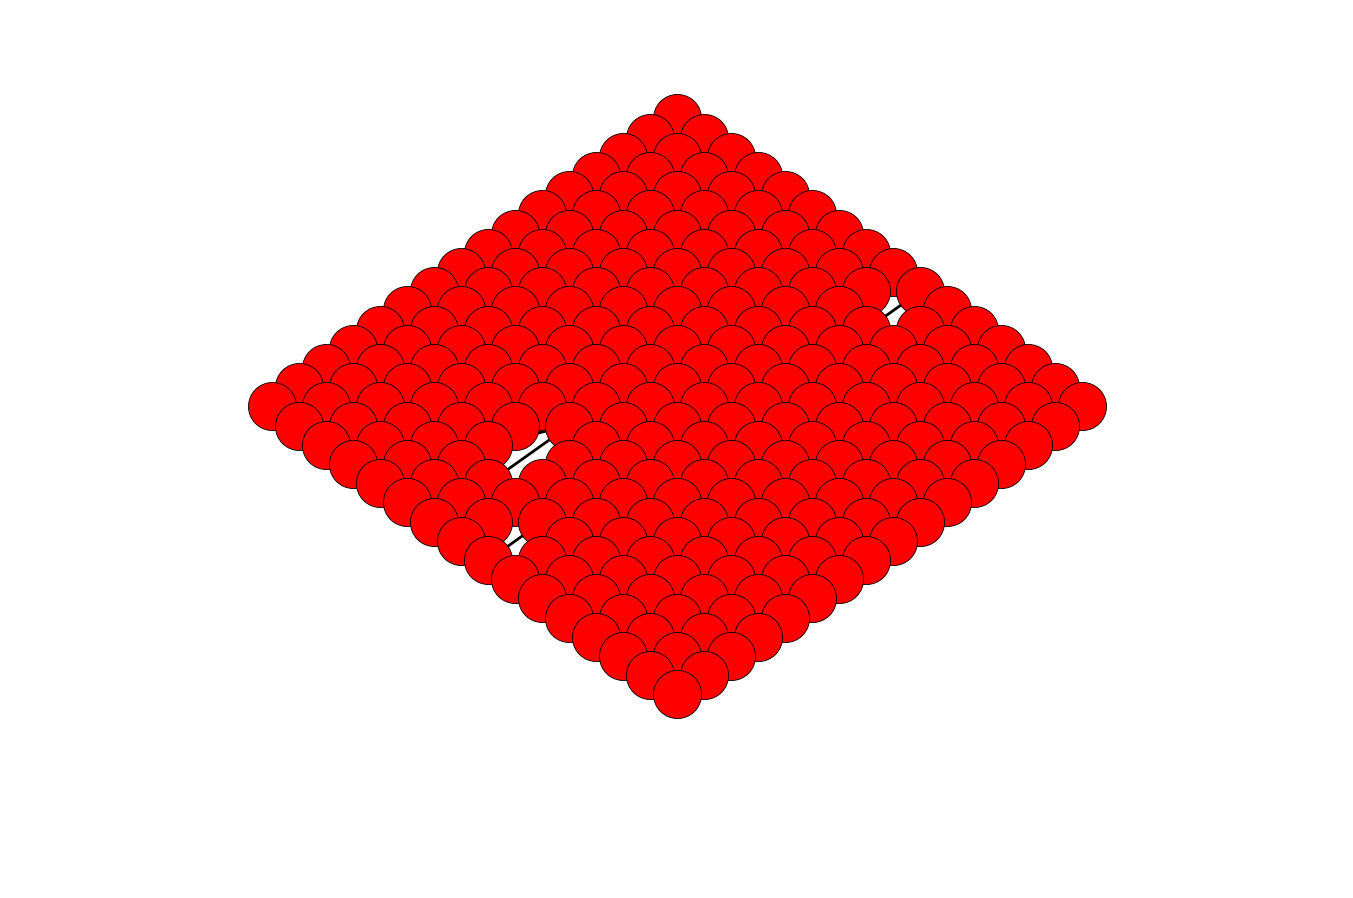

In [71]:
def pooled_variance(s, t):
    return (s['u'] * s['c'] + t['u'] * t['c']) / (s['c'] + t['c']) \
        + (s['c'] * t['c']) / (s['c'] + t['c'])**2 * (s['v'] - t['v']) ** 2
    
def merge(edge, graph):
    """Merges two nodes and combines the count, value, uncertainty, and cells"""
    s = graph.node[edge[0]]
    t = graph.node[edge[1]]
    
    # sum up counts
    count = s['c'] + t['c']
    # weighted average
    value = (s['v'] * s['c']  + t['v'] * t['c']) / (s['c'] + t['c'])
    # pooled variance
    uncertainty = pooled_variance(s, t)
    
    # print(s['u'], t['u'], uncertainty, variance_diff(graph, edge))
    
    # union the set of cells
    cells = s['cells'].union(t['cells'])
    
    H = nx.contracted_edge(graph, edge, self_loops=False)
    new_node = H.node[edge[0]]
    new_node['c'] = count
    new_node['v'] = value
    new_node['u'] = uncertainty
    new_node['cells'] = cells
    
    return H

def uncertainty_diff(graph, edge):
    """Absolute difference in uncertainty"""
    return abs(graph.node[edge[0]]['u'] - graph.node[edge[1]]['u'])

def variance_diff(graph, edge):
    """Sum of the differeced in the variance"""
    s = graph.node[edge[0]]
    t = graph.node[edge[1]]
    pooled = pooled_variance(s, t)
    return 2 * pooled - s['u'] - t['u']

def average_uncertainty(graph):
    u = 0.0
    for node in graph.nodes():
        u += graph.node[node]['u']
    return u

# contracted graph
CG = G

while True:
    # print(average_uncertainty(CG))
    
    # find the next edge to contract
    best_edge = min(CG.edges(), key=lambda x: variance_diff(CG, x))
    cost = variance_diff(CG, best_edge)
    if cost >= 0 or len(CG) == 1:
        break
    CG = merge(best_edge, CG)

nx.draw(CG, pos=positions)

In [72]:
# set the values form the graph back on the images

rand_ids = np.arange(len(CG))
np.random.shuffle(rand_ids)
CG = nx.convert_node_labels_to_integers(CG)

for node_id in CG.nodes():
    node = CG.node[node_id]
    for cell in node['cells']:
        counts[cell.x,cell.y] = node['c']
        values[cell.x,cell.y] = node['v']
        uncertainties[cell.x,cell.y] = node['u']

        # use shuffled ids so we can see differences in the ids
        ids[cell.x,cell.y] = rand_ids[node_id]

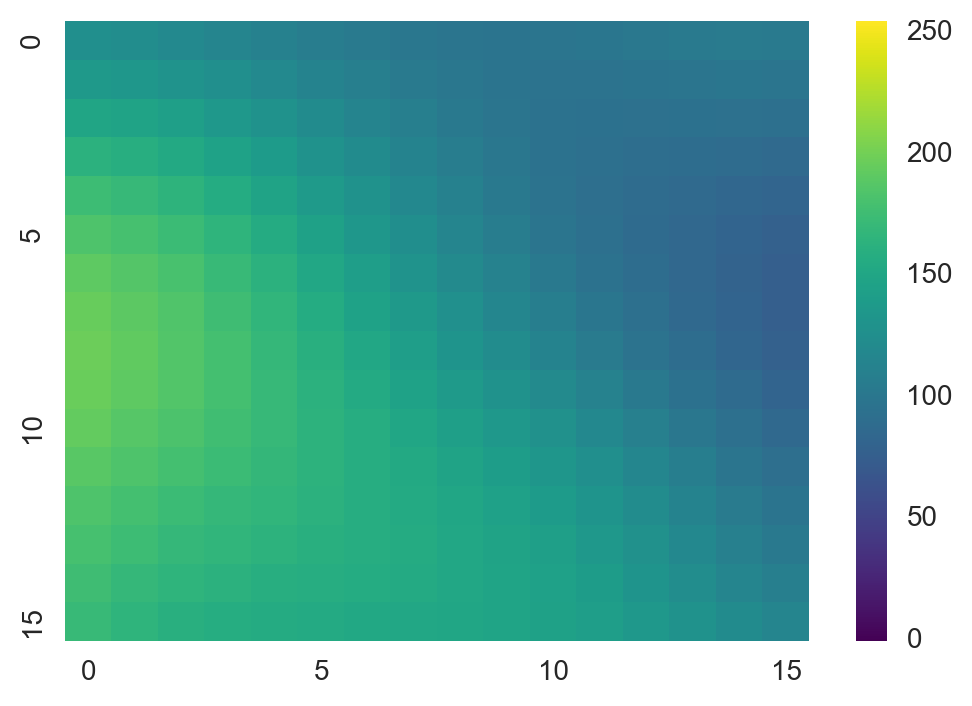

In [73]:
sns.heatmap(values, cmap='viridis', vmin=0, vmax=255, xticklabels=LABELS, yticklabels=LABELS)

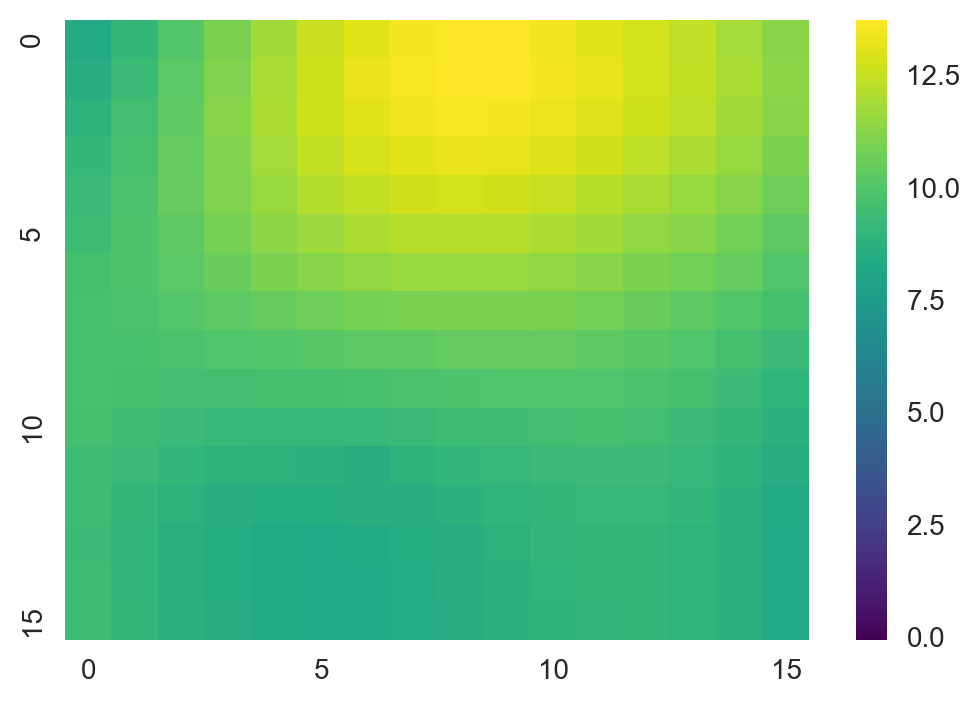

In [40]:
sns.heatmap(uncertainties, cmap='viridis', vmin=0, xticklabels=LABELS, yticklabels=LABELS)

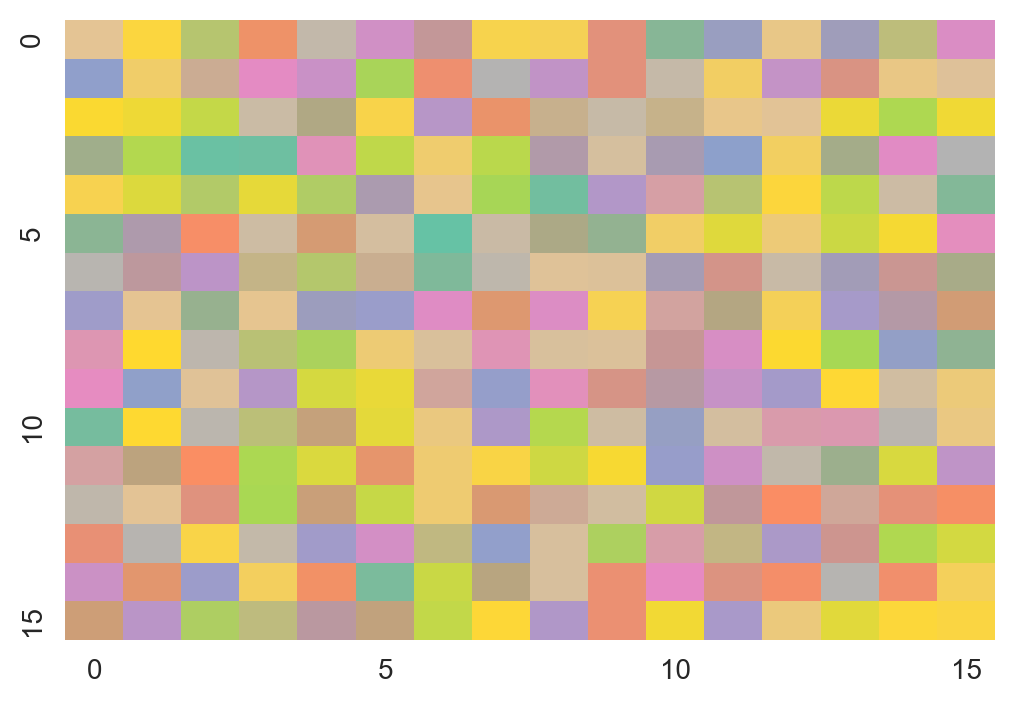

In [41]:
sns.heatmap(ids, cmap='Set2', xticklabels=LABELS, yticklabels=LABELS, cbar=False)